### capturing images for training

In [1]:
import os
import time
import cv2
import uuid

In [ ]:
IMAGES_PATH = os.path.join('DATA')
number_images = 30

In [ ]:
os.makedirs(IMAGES_PATH)

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
images = tf.data.Dataset.list_files('DATA/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

In [123]:
def load_image(image):
    byte_img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images

images are annotated using CVAT open source annotation tool

### visualize images

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [ ]:
with open('DATA/annotations/a7e25095-3640-11f0-b73e-e3dcb54b8daf.txt', 'r') as f:
    txt = f.read()

In [ ]:
txt_split = txt.replace('\n', '').split(' ')

In [ ]:
txt_split = [float(x) for x in txt_split[1:]]

In [ ]:
txt_split 

#### Setup albumentations pipeline

In [ ]:
import albumentations as alb

In [ ]:
agumentor = alb.Compose([alb.RandomCrop(height=450, width = 450),
                        alb.HorizontalFlip(p = 0.5),
                        alb.RandomBrightnessContrast(p = 0.5),
                        alb.RandomGamma(p = 0.5),
                        alb.RGBShift(p = 0.5)],
                        bbox_params=alb.BboxParams(format='yolo', label_fields=['class_labels']))

In [ ]:
for image in os.listdir(os.path.join('DATA', 'images'))

### Testing on a single image

In [ ]:
img = cv2.imread('DATA/images/a7e25095-3640-11f0-b73e-e3dcb54b8daf.jpg')

In [ ]:
plt.imshow(img)

In [ ]:
augmented = agumentor(image=img, bboxes = [txt_split], class_labels=['face'])

In [ ]:
augmented

In [ ]:
image_width, image_height = 450, 450  # Update with actual image size

# YOLO format bounding box (normalized values)
bbox = augmented['bboxes'][0]  # Example values
x_center, y_center, box_width, box_height = bbox

# Convert to pixel coordinates
x_center_pixel = x_center * image_width
y_center_pixel = y_center * image_height
width_pixel = box_width * image_width
height_pixel = box_height * image_height

# Compute xmin, ymin, xmax, ymax
x_min = int(x_center_pixel - width_pixel / 2)
y_min = int(y_center_pixel - height_pixel / 2)
x_max = int(x_center_pixel + width_pixel / 2)
y_max = int(y_center_pixel + height_pixel / 2)

In [ ]:
x_min, y_min, x_max, y_max

In [ ]:
cv2.rectangle(augmented['image'], 
              (x_min, y_min), (x_max, y_max), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### augmenting the images

In [4]:
import json

In [ ]:
for image in os.listdir('DATA/images'):
    img = cv2.imread(os.path.join('DATA/images', image))
    label_path = os.path.join('DATA/annotations',f'{image.split('.')[0]}.txt')
    with open(label_path, 'r') as f:
        txt = f.read()
    txt_split = txt.replace('\n', '').split(' ')
    yolo_coords = [float(x) for x in txt_split[1:]]
    try:
        for x in range(60):
            augmented = agumentor(image = img, bboxes=[yolo_coords], class_labels=['face'])
            cv2.imwrite(os.path.join('DATA/imgs', f'{image.split('.')[0]}.{x}.jpg'), augmented['image'])

            annotation = {}

            annotation['image'] = image

            if os.path.exists(label_path):
                if len(augmented['bboxes']) == 0: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                else: 
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1
            else: 
                annotation['bbox'] = [0,0,0,0]
                annotation['class'] = 0 

            with open(os.path.join('DATA/labels',f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                json.dump(annotation, f)
    except Exception as e:
        print(e)

### load all images and labels

In [ ]:
import tensorflow as tf

In [5]:
all_images = tf.data.Dataset.list_files('DATA/imgs/*.jpg', shuffle=False)
all_images = all_images.map(load_image)
all_images = all_images.map(lambda x: tf.image.resize(x, (120,120)))
all_images = all_images.map(lambda x: x/255)

In [6]:
type(all_images)

tensorflow.python.data.ops.map_op._MapDataset

In [7]:
all_images.as_numpy_iterator().next().shape

(120, 120, 3)

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [9]:
all_labels = tf.data.Dataset.list_files('DATA/labels/*.json', shuffle=False)
all_labels = all_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
type(all_labels)

tensorflow.python.data.ops.map_op._MapDataset

In [11]:
all_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.629 , 0.4412, 0.4663, 0.508 ], dtype=float16))

In [12]:
len(all_images), len(all_labels)

(5400, 5400)

In [13]:
all_data = tf.data.Dataset.zip((all_images, all_labels))

In [14]:
type(all_data)

tensorflow.python.data.ops.zip_op._ZipDataset

In [15]:
all_data.as_numpy_iterator().next()

(array([[[0.15680148, 0.11758579, 0.11219363],
         [0.15183823, 0.12138481, 0.11176471],
         [0.16323529, 0.1367647 , 0.13382353],
         ...,
         [0.43933824, 0.43492648, 0.40208334],
         [0.4439338 , 0.43952206, 0.41219363],
         [0.438174  , 0.43131128, 0.4132353 ]],
 
        [[0.16507353, 0.12371323, 0.1158701 ],
         [0.15245098, 0.1127451 , 0.10490196],
         [0.16856618, 0.12395833, 0.10876226],
         ...,
         [0.4612745 , 0.4495098 , 0.3827206 ],
         [0.4536152 , 0.42794117, 0.3867647 ],
         [0.4473652 , 0.4189338 , 0.38707107]],
 
        [[0.1504902 , 0.11127451, 0.11164216],
         [0.14852941, 0.10833333, 0.10490196],
         [0.16072305, 0.10582108, 0.10189951],
         ...,
         [0.4417892 , 0.4300245 , 0.3702206 ],
         [0.44773284, 0.42224264, 0.3810049 ],
         [0.43621323, 0.40876225, 0.36954656]],
 
        ...,
 
        [[0.12824754, 0.07334559, 0.03020833],
         [0.14307599, 0.08817402, 0.03719

In [16]:
all_data = all_data.shuffle(6000)

### Train Test Val split

In [17]:
train_data = all_data.take(4320)
val_data = all_data.skip(4320).take(540)
test_data = all_data.skip(4860).take(540)

In [18]:
train_data = train_data.batch(8)
train_data = train_data.prefetch(4)

val_data = val_data.batch(8)
val_data = val_data.prefetch(4)

test_data = test_data.batch(8)
test_data = test_data.prefetch(4)

#### visualizing the dataset

In [19]:
data_samples = train_data.as_numpy_iterator()

In [20]:
res = data_samples.next()

In [21]:
res

(array([[[[7.11764693e-01, 8.10784340e-01, 9.02450979e-01],
          [7.31433809e-01, 8.18627477e-01, 9.10661757e-01],
          [7.27450967e-01, 8.33333313e-01, 9.07843113e-01],
          ...,
          [1.32352948e-01, 1.25000000e-01, 9.60784331e-02],
          [1.10784315e-01, 1.02144606e-01, 8.13725516e-02],
          [1.40747547e-01, 1.25919119e-01, 1.02941178e-01]],
 
         [[7.21752465e-01, 8.20772052e-01, 9.12438750e-01],
          [7.32720613e-01, 8.19117665e-01, 9.12806392e-01],
          [7.16666639e-01, 8.25919092e-01, 9.08823550e-01],
          ...,
          [1.21629901e-01, 1.25551477e-01, 9.41789225e-02],
          [1.11764707e-01, 1.16544120e-01, 9.16053951e-02],
          [1.09313726e-01, 1.13602944e-01, 8.49877447e-02]],
 
         [[7.09007382e-01, 8.05882335e-01, 8.95404398e-01],
          [7.05269635e-01, 7.91666687e-01, 8.82352948e-01],
          [6.64950967e-01, 7.70343125e-01, 8.53676498e-01],
          ...,
          [1.25980392e-01, 1.25980392e-01, 9.4607

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


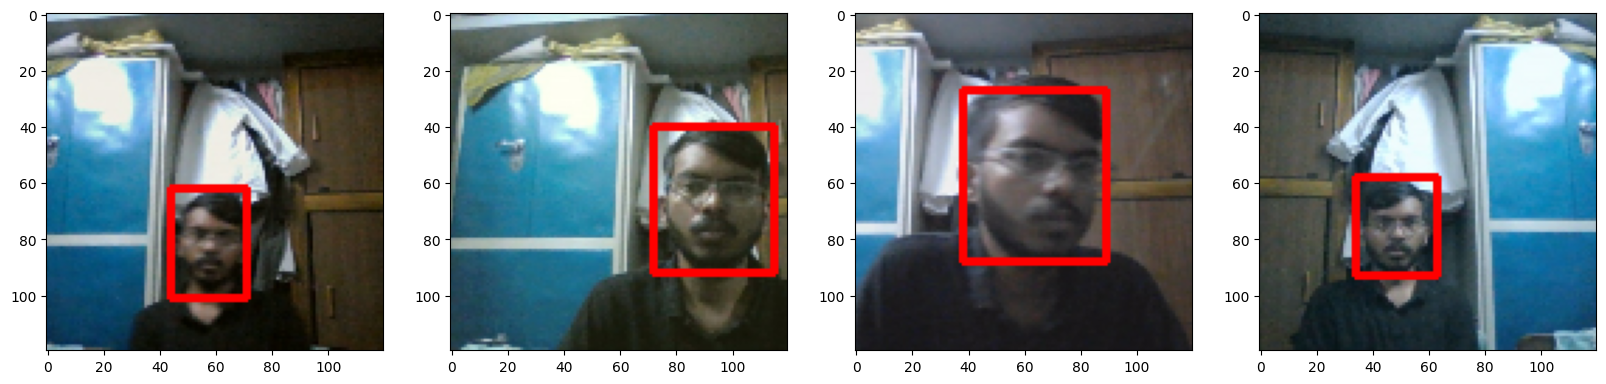

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    # print(sample_image)
    sample_image = sample_image.copy()
    # plt.imshow(sample_image)
    image_width, image_height = 120, 120  # Update with actual image size
    # print(sample_coords)
    x_center, y_center, box_width, box_height = sample_coords 
    
    # Convert to pixel coordinates
    x_center_pixel = x_center * image_width
    y_center_pixel = y_center * image_height
    width_pixel = box_width * image_width
    height_pixel = box_height * image_height
    
    # Compute xmin, ymin, xmax, ymax
    x_min = int(x_center_pixel - width_pixel / 2)
    y_min = int(y_center_pixel - height_pixel / 2)
    x_max = int(x_center_pixel + width_pixel / 2)
    y_max = int(y_center_pixel + height_pixel / 2)
    cv2.rectangle(sample_image, (x_min, y_min), (x_max, y_max), (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Building deep learning model

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [55]:
vgg = VGG16(include_top = False)

In [56]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top = False)(input_layer)

    f1  = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])

    return facetracker

testing the model

In [58]:
facetracker = build_model()

In [59]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_2        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_3        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_3[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │           2,049 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 4)                 │           8,196 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [164]:
# below example is to test the model output

In [60]:
X, y = train_data.as_numpy_iterator().next()

In [61]:
X.shape

(8, 120, 120, 3)

In [62]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


In [63]:
classes, coords

(array([[0.46727553],
        [0.46191823],
        [0.44337648],
        [0.45247808],
        [0.45799625],
        [0.44238827],
        [0.39427373],
        [0.49527398]], dtype=float32),
 array([[0.5331724 , 0.6684072 , 0.5592482 , 0.7674883 ],
        [0.45696384, 0.5034462 , 0.65764135, 0.72795075],
        [0.48569712, 0.4701403 , 0.59472513, 0.7438326 ],
        [0.44357678, 0.56308097, 0.6339751 , 0.73805773],
        [0.48316073, 0.6365298 , 0.66645825, 0.74753916],
        [0.4808702 , 0.48328778, 0.5578547 , 0.7693418 ],
        [0.43485403, 0.5135372 , 0.6278154 , 0.7947686 ],
        [0.52300507, 0.5357472 , 0.5354639 , 0.6820202 ]], dtype=float32))

### learning rate

In [64]:
facetracker

<Functional name=functional_1, built=True>

In [65]:
batches_per_epoch = len(train_data)
lr_decay = (1./0.75 - 1) / batches_per_epoch
initial_learning_rate = 0.0001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=batches_per_epoch,  # Apply decay every batch
    decay_rate=1 - lr_decay,  # Adjust decay rate accordingly
    staircase=True 
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### Define loss function and optimizers

In [66]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [165]:
regressloss = localization_loss

In [69]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8830437660217285>

In [71]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.8830437660217285>

In [72]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

    # Compute BCE
    loss = -tf.reduce_mean(tf.cast(y_true, dtype=tf.float32) * tf.math.log(y_pred) + (1 - tf.cast(y_true, dtype=tf.float32)) * tf.math.log(1 - y_pred))

    return loss

In [73]:
binary_cross_entropy(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7961713671684265>

### Custom Compile, Train, Test

In [74]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = binary_cross_entropy
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            # print(y[0])
            # print(tf.convert_to_tensor(classes))
            # print(tf.cast(y[0], dtype=tf.float32) - classes)
            batch_classloss = self.closs(tf.cast(y[0], dtype=tf.float32), classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [86]:
model = FaceTracker(facetracker)

In [96]:
model.compile(opt, classloss, regressloss)

In [97]:
model

<FaceTracker name=face_tracker_2, built=True>

In [98]:
model.build

<function keras.src.layers.layer.Layer.build(input_shape)>

### Train

In [99]:
logdir='logs'

In [100]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [166]:
checkpoint_path = "./training/cp3-{epoch:04d}.weights.h5"

# callback to save weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only = True,
    save_freq='epoch'  # Save after every epoch
)

In [103]:
hist = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[cp_callback])

Epoch 1/10

Epoch 1: saving model to ./training/cp3-0001.weights.h5
540/540 ━━━━━━━━━━━━━━━━━━━━ 517s 937ms/step - class_loss: 0.0058 - regress_loss: 0.0930 - total_loss: 0.0959 - val_class_loss: 3.5436e-05 - val_regress_loss: 0.0103 - val_total_loss: 0.0103
Epoch 2/10

Epoch 2: saving model to ./training/cp3-0002.weights.h5
540/540 ━━━━━━━━━━━━━━━━━━━━ 520s 955ms/step - class_loss: 1.5627e-05 - regress_loss: 0.0139 - total_loss: 0.0139 - val_class_loss: 4.6343e-06 - val_regress_loss: 0.0049 - val_total_loss: 0.0049
Epoch 3/10

Epoch 3: saving model to ./training/cp3-0003.weights.h5
540/540 ━━━━━━━━━━━━━━━━━━━━ 532s 976ms/step - class_loss: 4.3442e-06 - regress_loss: 0.0106 - total_loss: 0.0106 - val_class_loss: 3.7402e-06 - val_regress_loss: 0.0026 - val_total_loss: 0.0026
Epoch 4/10

Epoch 4: saving model to ./training/cp3-0004.weights.h5
540/540 ━━━━━━━━━━━━━━━━━━━━ 553s 1s/step - class_loss: 2.2712e-06 - regress_loss: 0.0092 - total_loss: 0.0092 - val_class_loss: 2.3246e-06 - val_r

In [110]:
hist.history

{'class_loss': [2.3142456484492868e-05,
  4.090387847099919e-06,
  7.003550877016096e-07,
  3.1367112569569144e-06,
  8.493674954479502e-07,
  7.30157353245886e-07,
  7.003551445450285e-07,
  2.98023280720372e-07,
  1.4975682915974176e-06,
  1.0132799843631801e-06],
 'regress_loss': [0.021376747637987137,
  0.014921584166586399,
  0.013562220148742199,
  0.008283745497465134,
  0.006326543632894754,
  0.005750392097979784,
  0.002398113254457712,
  0.013468162156641483,
  0.0037523191422224045,
  0.008718244731426239],
 'total_loss': [0.02138831838965416,
  0.014923629350960255,
  0.013562570326030254,
  0.008285313844680786,
  0.006326968315988779,
  0.005750757176429033,
  0.0023984634317457676,
  0.013468311168253422,
  0.0037530679255723953,
  0.00871875137090683],
 'val_class_loss': [3.543584898579866e-05,
  4.634281594917411e-06,
  3.7402135149022797e-06,
  2.3245872853294713e-06,
  2.1308694613253465e-06,
  5.215410396886e-07,
  7.301574669327238e-07,
  9.089713444154768e-07,
  

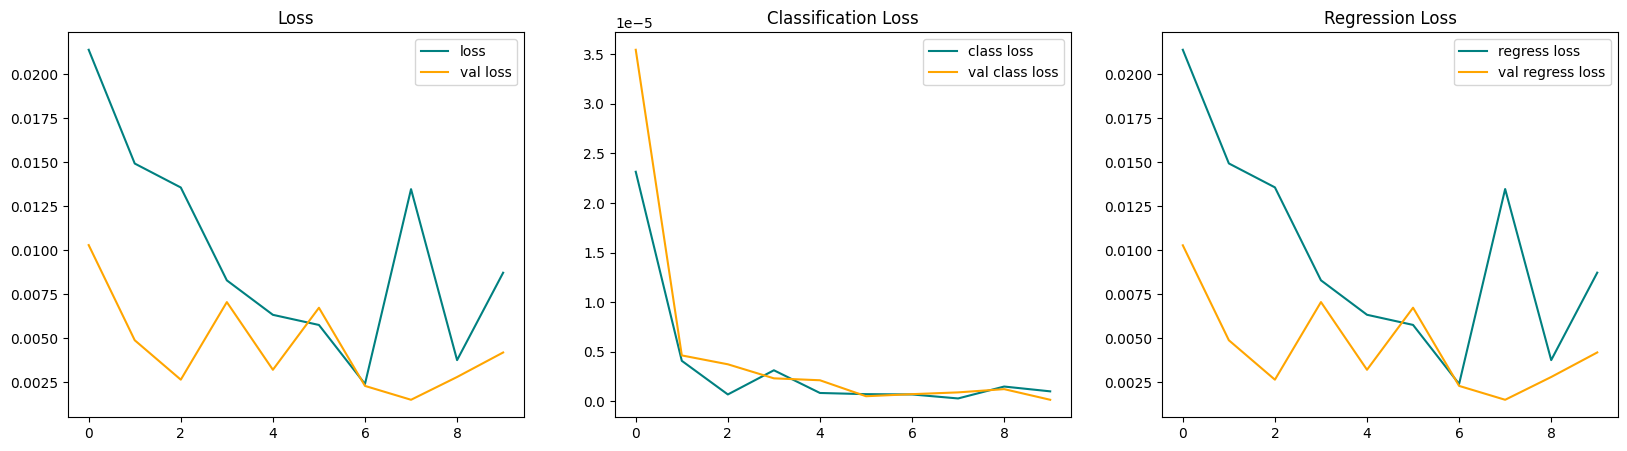

In [111]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [112]:
test_sample = test_data.as_numpy_iterator()

In [113]:
test_sample.next()[0]

array([[[[3.04411769e-01, 3.22610289e-01, 3.85784328e-01],
         [3.36213231e-01, 3.28860283e-01, 3.89460772e-01],
         [4.62622553e-01, 4.34620112e-01, 4.82843131e-01],
         ...,
         [3.03431362e-01, 3.07352930e-01, 3.15196067e-01],
         [2.98039228e-01, 3.01960796e-01, 3.09803933e-01],
         [3.11887264e-01, 3.15808833e-01, 3.23651969e-01]],

        [[4.76225495e-01, 4.92401958e-01, 5.63664198e-01],
         [5.79963207e-01, 5.75980365e-01, 6.34987772e-01],
         [6.83088243e-01, 6.75735295e-01, 7.16421545e-01],
         ...,
         [3.05392146e-01, 3.09313715e-01, 3.18137258e-01],
         [3.02389711e-01, 3.06311280e-01, 3.22426468e-01],
         [2.94485301e-01, 2.99325973e-01, 3.14705878e-01]],

        [[7.06372559e-01, 7.10294127e-01, 7.19117641e-01],
         [7.09803939e-01, 7.09803939e-01, 7.10784316e-01],
         [7.13725507e-01, 7.13725507e-01, 7.13848054e-01],
         ...,
         [2.90196091e-01, 3.05882365e-01, 3.17647070e-01],
         [

In [117]:
yhat = model.predict(test_sample.next()[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


In [115]:
model.load_weights('training/cp3-0008.weights.h5')

In [116]:
model.build(test_sample.next()[0])

In [118]:
yhat

[array([[0.99999946],
        [0.9999992 ],
        [0.999999  ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.99999994],
        [1.        ]], dtype=float32),
 array([[0.25520423, 0.518172  , 0.3478351 , 0.4563169 ],
        [0.3783573 , 0.4836748 , 0.45908493, 0.5437071 ],
        [0.36941656, 0.5179267 , 0.35774067, 0.45542675],
        [0.6312984 , 0.6301733 , 0.24507286, 0.30926102],
        [0.14399974, 0.54182625, 0.28660062, 0.5649098 ],
        [0.5487603 , 0.6873548 , 0.23213169, 0.28731367],
        [0.58955574, 0.33278435, 0.31986782, 0.39295614],
        [0.8373474 , 0.64355737, 0.25033188, 0.31223026]], dtype=float32)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


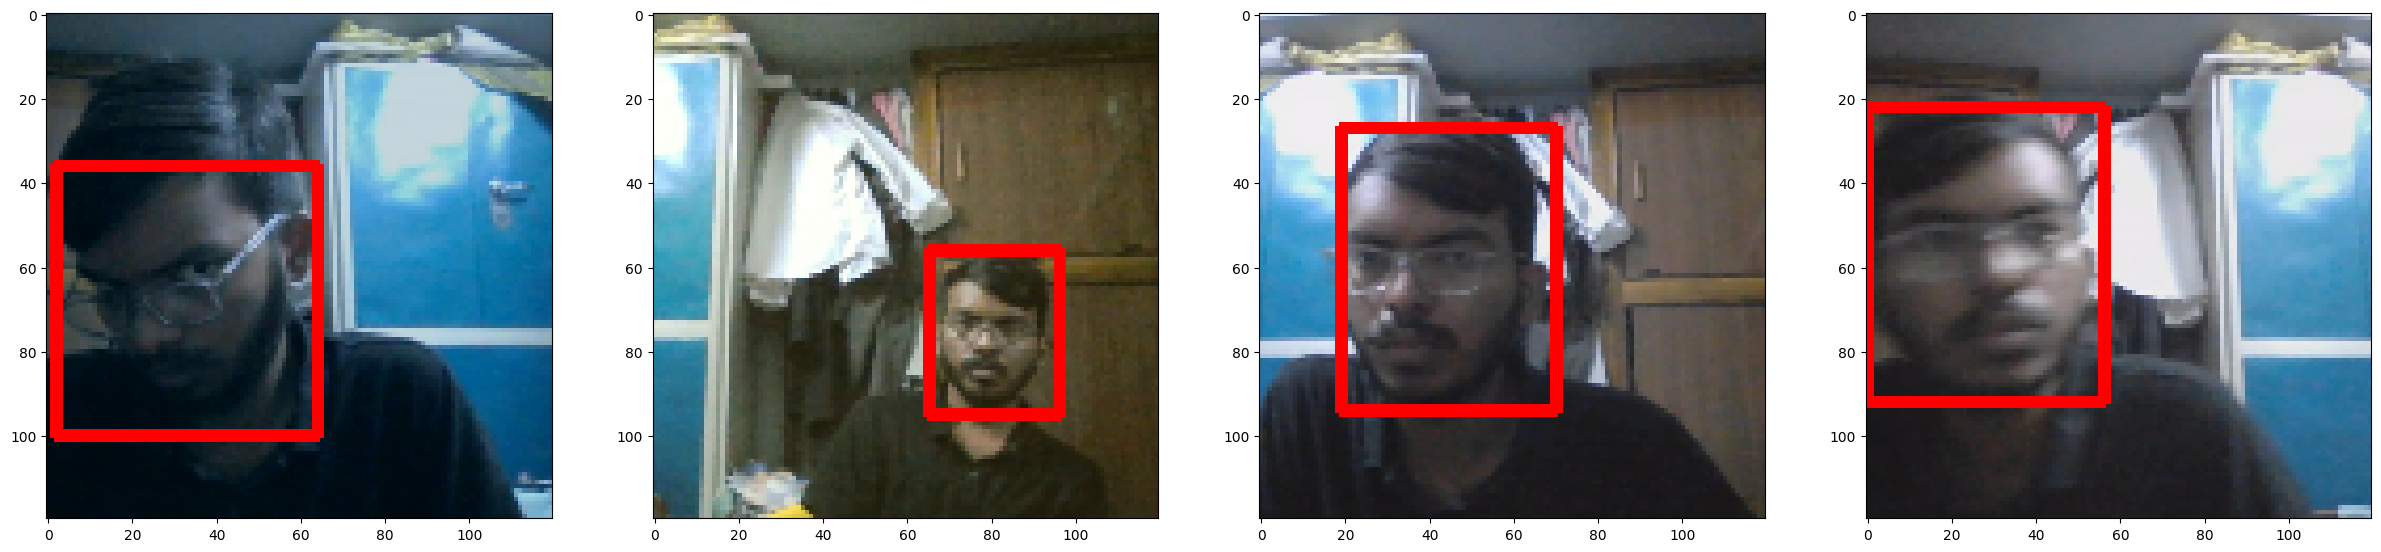

In [153]:
fig, ax = plt.subplots(ncols=4, figsize=(30,30))
for idx in range(4): 
    sample_img = test_sample.next()[0]
    sample_image = sample_img[idx]
    sample_coords = facetracker.predict(sample_img)[1][idx]
    image_width, image_height = 120, 120  # Update with actual image size
    sample_image = sample_image.copy()
    # print(sample_coords)
    x_center, y_center, box_width, box_height = sample_coords 
    
    # Convert to pixel coordinates
    x_center_pixel = x_center * image_width
    y_center_pixel = y_center * image_height
    width_pixel = box_width * image_width
    height_pixel = box_height * image_height
    
    # Compute xmin, ymin, xmax, ymax
    x_min = int(x_center_pixel - width_pixel / 2)
    y_min = int(y_center_pixel - height_pixel / 2)
    x_max = int(x_center_pixel + width_pixel / 2)
    y_max = int(y_center_pixel + height_pixel / 2)
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      (x_min, y_min), (x_max, y_max), (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Real time visualization

In [133]:
facetracker.save('facetracker.h5')

In [136]:
facetracker = tf.keras.models.load_model('facetracker.h5')

In [163]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    # frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        image_width, image_height = 640, 480
        x_center, y_center, box_width, box_height = sample_coords 
        
        x_center_pixel = x_center * image_width
        y_center_pixel = y_center * image_height
        width_pixel = box_width * image_width
        height_pixel = box_height * image_height
        
        # Compute xmin, ymin, xmax, ymax
        x_min = int(x_center_pixel - width_pixel / 2)
        y_min = int(y_center_pixel - height_pixel / 2)
        x_max = int(x_center_pixel + width_pixel / 2)
        y_max = int(y_center_pixel + height_pixel / 2)
        # Controls the main rectangle
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), 
                            (0,255,0), 2)
    # print(frame.shape)
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━